## Notebook Overview

This notebook includes:
- Simple baseline regression models  
- A full LightGBM pipeline with preprocessing and feature engineering  

The final LightGBM model achieves a **Public Leaderboard RMSE = 2.579**.


In [10]:
import joblib

data = joblib.load("notebook1_full_dump.joblib")

train_df = data["train_df"]
test_df  = data["test_df"]

metric_names = data["metric_names"]
metric_to_idx = data["metric_to_idx"]
metric_embeddings = data["metric_embeddings"]

train_metric_idx = data["train_metric_idx"]
test_metric_idx  = data["test_metric_idx"]

train_user = data["train_user"]
train_sys  = data["train_sys"]
train_resp = data["train_resp"]
train_comb = data["train_comb"]

test_user = data["test_user"]
test_sys  = data["test_sys"]
test_resp = data["test_resp"]
test_comb = data["test_comb"]

print("Loaded Notebook1 dump successfully!")


Loaded Notebook1 dump successfully!


### Build Baseline Features

In [11]:
import numpy as np
import pandas as pd

def cosine_sim(a, b):
    dot = np.sum(a * b, axis=1)
    denom = np.linalg.norm(a, axis=1) * np.linalg.norm(b, axis=1) + 1e-8
    return dot / denom

print("Building baseline embedding features...")

metric_vecs_train = metric_embeddings[train_metric_idx]
metric_vecs_test  = metric_embeddings[test_metric_idx]

def build_features(resp, user, sys, metric_vecs, df):
    feat = pd.DataFrame()
    feat["cos_resp_metric"] = cosine_sim(resp, metric_vecs)
    feat["cos_user_resp"]   = cosine_sim(user, resp)
    feat["cos_user_metric"] = cosine_sim(user, metric_vecs)
    feat["cos_sys_resp"]    = cosine_sim(sys, resp)
    feat["cos_sys_metric"]  = cosine_sim(sys, metric_vecs)

    diff = resp - metric_vecs
    feat["l2_diff"] = np.linalg.norm(diff, axis=1)
    feat["l1_diff"] = np.abs(diff).sum(axis=1)

    feat["resp_norm"]   = np.linalg.norm(resp, axis=1)
    feat["user_norm"]   = np.linalg.norm(user, axis=1)
    feat["metric_norm"] = np.linalg.norm(metric_vecs, axis=1)

    feat["sys_missing_flag"] = (df["system_prompt"].astype(str).str.strip() == "").astype(int).values
    feat["metric_idx"] = df["metric_idx"].astype(int).astype(str)

    return feat

X_train = build_features(train_resp, train_user, train_sys, metric_vecs_train, train_df)
X_test  = build_features(test_resp, test_user, test_sys, metric_vecs_test,  test_df)

y = train_df["score"].astype(float).values

print("Feature shapes:", X_train.shape, X_test.shape)


Building baseline embedding features...
Feature shapes: (5000, 12) (3638, 12)


### Train Linear Regression

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
import math

def rmse(a,b): return math.sqrt(mean_squared_error(a,b))

print("\nTraining Linear Regression...")

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train[num_cols])

kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_lr = np.zeros(len(X_train))

for fold, (tr, val) in enumerate(kf.split(X_scaled), 1):
    lr = LinearRegression()
    lr.fit(X_scaled[tr], y[tr])
    pred = lr.predict(X_scaled[val])
    oof_lr[val] = pred
    print(f"Fold {fold}: RMSE={rmse(y[val], pred):.4f}")

lr_rmse = rmse(y, oof_lr)
lr_mae  = mean_absolute_error(y, oof_lr)
lr_r2   = r2_score(y, oof_lr)
print(f"\nFinal LR OOF: RMSE={lr_rmse:.4f}, MAE={lr_mae:.4f}, R2={lr_r2:.4f}")

# Inference
test_lr = lr.predict(scaler.transform(X_test[num_cols]))




Training Linear Regression...
Fold 1: RMSE=0.9432
Fold 2: RMSE=0.8198
Fold 3: RMSE=0.8841
Fold 4: RMSE=1.0066
Fold 5: RMSE=1.0126

Final LR OOF: RMSE=0.9362, MAE=0.5103, R2=0.0130


### Train LightGBM  Regressor

In [15]:
import lightgbm as lgb

print("\nTraining LightGBM Regressor...")

X_lgb = X_train.copy()
X_lgb["metric_idx"] = X_lgb["metric_idx"].astype("category")

test_lgb_df = X_test.copy()
test_lgb_df["metric_idx"] = test_lgb_df["metric_idx"].astype("category")

lgb_oof = np.zeros(len(X_train))
lgb_models = []

params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.03,
    "num_leaves": 63,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "min_data_in_leaf": 20,
    "device": "gpu",
    "verbosity": -1
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold,(tr,val) in enumerate(kf.split(X_lgb),1):
    dtrain = lgb.Dataset(X_lgb.iloc[tr], label=y[tr], categorical_feature=["metric_idx"])
    dvalid = lgb.Dataset(X_lgb.iloc[val], label=y[val], reference=dtrain)

    model = lgb.train(
        params,
        dtrain,
        num_boost_round=2000,
        valid_sets=[dtrain, dvalid],
        callbacks=[lgb.early_stopping(350)]
    )

    pred = model.predict(X_lgb.iloc[val])
    lgb_oof[val] = pred
    lgb_models.append(model)
    print(f"Fold {fold}: RMSE={rmse(y[val], pred):.4f}")

lgb_rmse = rmse(y, lgb_oof)
lgb_mae  = mean_absolute_error(y, lgb_oof)
lgb_r2   = r2_score(y, lgb_oof)

print(f"\nFinal LGB OOF: RMSE={lgb_rmse:.4f}, MAE={lgb_mae:.4f}, R2={lgb_r2:.4f}")

# Inference
test_lgb = np.mean([m.predict(test_lgb_df) for m in lgb_models], axis=0)



Training LightGBM Regressor...
Training until validation scores don't improve for 350 rounds
Early stopping, best iteration is:
[78]	training's rmse: 0.705717	valid_1's rmse: 0.89591
Fold 1: RMSE=0.8959
Training until validation scores don't improve for 350 rounds
Early stopping, best iteration is:
[40]	training's rmse: 0.812269	valid_1's rmse: 0.777305
Fold 2: RMSE=0.7773
Training until validation scores don't improve for 350 rounds
Early stopping, best iteration is:
[39]	training's rmse: 0.798451	valid_1's rmse: 0.852505
Fold 3: RMSE=0.8525
Training until validation scores don't improve for 350 rounds
Early stopping, best iteration is:
[62]	training's rmse: 0.725971	valid_1's rmse: 0.959176
Fold 4: RMSE=0.9592
Training until validation scores don't improve for 350 rounds
Early stopping, best iteration is:
[63]	training's rmse: 0.720768	valid_1's rmse: 0.971677
Fold 5: RMSE=0.9717

Final LGB OOF: RMSE=0.8942, MAE=0.5146, R2=0.0996


### Train CatBoost Classifier (Rounded Score Prediction)

In [16]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

print("\n4) Training CatBoostClassifier (rounded score classes)...")

ALL_CLASSES = np.arange(11)                   # 0..10
y_class = np.clip(np.round(y).astype(int), 0, 10)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

clf_oof_proba = np.zeros((len(y_class), len(ALL_CLASSES)))
clf_pred_class = np.zeros(len(y_class), dtype=int)
clf_models = []

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_class), 1):
    print(f"\n=== Fold {fold} ===")

    X_tr = X_train.iloc[tr_idx].reset_index(drop=True)
    X_val = X_train.iloc[val_idx].reset_index(drop=True)

    y_tr = y_class[tr_idx]
    y_val = y_class[val_idx]

    # -------------------------------
    # Remove validation samples with unseen labels
    # -------------------------------
    train_classes = set(y_tr)
    val_mask = np.array([yv in train_classes for yv in y_val])

    if val_mask.sum() == 0:
        print("Skipping fold — no overlapping classes!")
        continue

    X_val = X_val[val_mask]
    y_val = y_val[val_mask]
    true_val_idx = val_idx[val_mask]

    pool_tr = Pool(X_tr, y_tr, cat_features=["metric_idx"])
    pool_val = Pool(X_val, y_val, cat_features=["metric_idx"])

    clf = CatBoostClassifier(
        iterations=2000,
        learning_rate=0.03,
        depth=6,
        loss_function="MultiClass",
        eval_metric="TotalF1:average=Macro",
        task_type="GPU",
        early_stopping_rounds=200,
        verbose=200,
        random_seed=42 + fold
    )

    clf.fit(pool_tr, eval_set=pool_val)

    # probas only for classes seen in train
    model_classes = clf.classes_                 # e.g. [0,1,2,3,4,6,7,8,9,10]
    probs = clf.predict_proba(X_val)             # shape (N, K)

    # -------------------------------
    # ALWAYS pad probabilities to (N, 11)
    # -------------------------------
    padded = np.zeros((probs.shape[0], len(ALL_CLASSES)))
    for j, cls in enumerate(model_classes):
        padded[:, cls] = probs[:, j]

    # Save back
    clf_oof_proba[true_val_idx] = padded
    clf_pred_class[true_val_idx] = padded.argmax(axis=1)
    clf_models.append(clf)

# Metrics
clf_acc = accuracy_score(y_class, clf_pred_class)
clf_f1  = f1_score(y_class, clf_pred_class, average="macro")

print("\nCatBoostClassifier OOF:")
print("Accuracy:", round(clf_acc,4))
print("Macro-F1:", round(clf_f1,4))



4) Training CatBoostClassifier (rounded score classes)...

=== Fold 1 ===
0:	learn: 0.0739183	test: 0.0718310	best: 0.0718310 (0)	total: 20.8ms	remaining: 41.6s
200:	learn: 0.1164425	test: 0.1037437	best: 0.1042803 (198)	total: 3.99s	remaining: 35.7s
400:	learn: 0.1250095	test: 0.1030245	best: 0.1047465 (212)	total: 7.9s	remaining: 31.5s
bestTest = 0.1047465337
bestIteration = 212
Shrink model to first 213 iterations.

=== Fold 2 ===
0:	learn: 0.0802607	test: 0.0805692	best: 0.0805692 (0)	total: 19.5ms	remaining: 38.9s
200:	learn: 0.1149170	test: 0.1039589	best: 0.1044300 (188)	total: 3.95s	remaining: 35.4s
400:	learn: 0.1216994	test: 0.1057541	best: 0.1069531 (260)	total: 7.74s	remaining: 30.8s
bestTest = 0.1069530812
bestIteration = 260
Shrink model to first 261 iterations.

=== Fold 3 ===
0:	learn: 0.0815976	test: 0.0726881	best: 0.0726881 (0)	total: 22.3ms	remaining: 44.5s
200:	learn: 0.1131459	test: 0.1030463	best: 0.1038656 (191)	total: 3.85s	remaining: 34.5s
400:	learn: 0.12068

In [19]:
ALL_CLASSES = np.arange(11)  # 0..10

test_cat_df = X_test.copy()
test_cat_df["metric_idx"] = test_cat_df["metric_idx"].astype(str)

test_clf_proba_list = []

for m in clf_models:
    probs = m.predict_proba(test_cat_df)      # shape (N, K)
    model_classes = m.classes_                # shape (K,)
    
    padded = np.zeros((probs.shape[0], len(ALL_CLASSES)))
    
    # fill the correct columns
    for j, cls in enumerate(model_classes):
        padded[:, cls] = probs[:, j]
    
    test_clf_proba_list.append(padded)

# Mean across models
test_clf_proba = np.mean(test_clf_proba_list, axis=0)
test_clf = test_clf_proba.argmax(axis=1)


### Plot Test Prediction Distributions

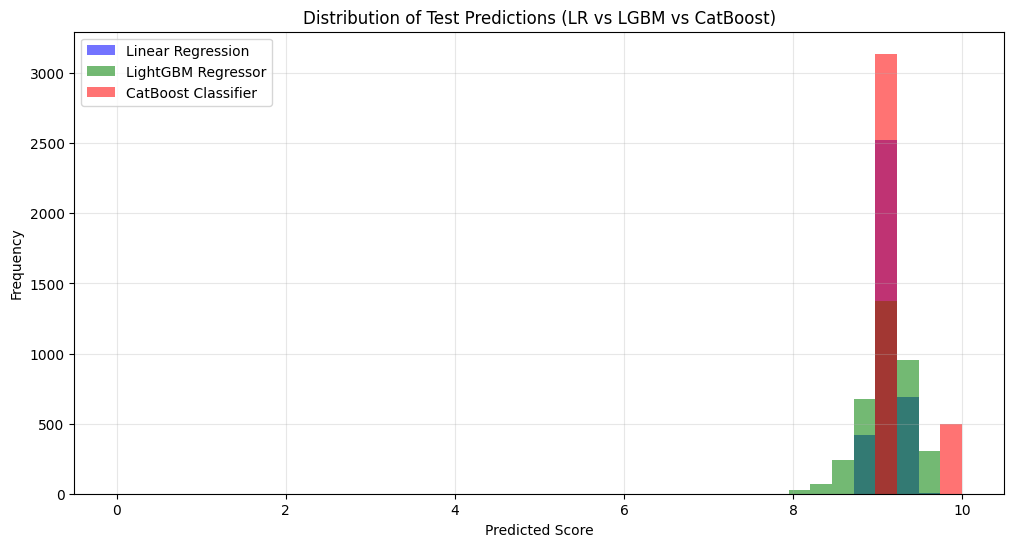

In [20]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))

bins = np.linspace(0, 10, 40)

plt.hist(test_lr,  bins=bins, alpha=0.55, label="Linear Regression", color="blue")
plt.hist(test_lgb, bins=bins, alpha=0.55, label="LightGBM Regressor", color="green")

# If classifier predictions exist
if 'test_clf' in globals():
    plt.hist(test_clf, bins=bins, alpha=0.55, label="CatBoost Classifier", color="red")

plt.title("Distribution of Test Predictions (LR vs LGBM vs CatBoost)")
plt.xlabel("Predicted Score")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Real feature matrix : (5000, 1536)
Real score vector   : (5000,)

Final Shapes After Augmentation:
X_aug      : (20000, 1536)
y_aug      : (20000,)
metric_aug : (20000,)

All augmented arrays saved successfully.


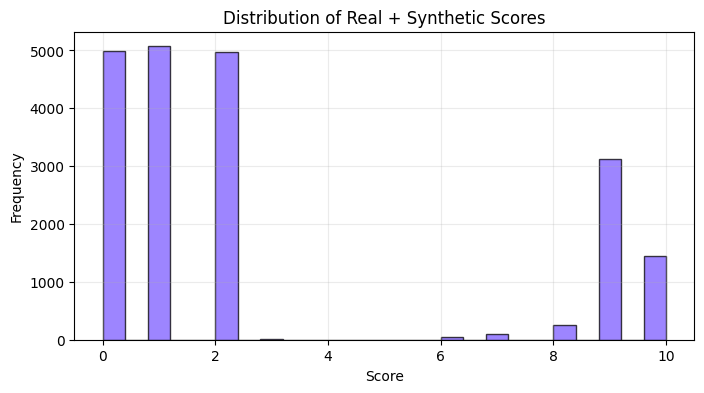

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reproducible random generator
rng = np.random.default_rng(42)

# ---------------------------------------------------------
# 1) Prepare the real embeddings and labels
# ---------------------------------------------------------
X_real = train_comb.astype(np.float32)                 # text embeddings (N × 768)
y_real = train_df["score"].values.astype(np.float32)   # target scores
metric_real = train_df["metric_id"].values.astype(int) # metric IDs

num_samples = len(X_real)

# Metric vector lookup table (145 × 768)
metric_emb = np.load("metric_name_embeddings.npy").astype(np.float32)

# Combine text and corresponding metric vector → (768 + 768 = 1536)
metric_vec = metric_emb[metric_real]
X_real_full = np.hstack([X_real, metric_vec])

print("Real feature matrix :", X_real_full.shape)
print("Real score vector   :", y_real.shape)

# ---------------------------------------------------------
# 2) Create three types of synthetic negatives
# ---------------------------------------------------------

# --------- a) Negative set 1: mismatched text ---------
shuffle_idx = rng.permutation(num_samples)
neg1_text = X_real[shuffle_idx]
neg1_all  = np.hstack([neg1_text, metric_vec])
y_neg1    = rng.integers(0, 3, size=num_samples).astype(np.float32)


# --------- b) Negative set 2: add noise to text ---------
noise = rng.normal(scale=0.6, size=X_real.shape)  # controlled noise
neg2_text = X_real + noise
neg2_all  = np.hstack([neg2_text, metric_vec])
y_neg2    = rng.integers(0, 3, size=num_samples).astype(np.float32)


# --------- c) Negative set 3: mismatch metric vector ---------
shuffle_idx_2 = rng.permutation(num_samples)
metric_swapped = metric_vec[shuffle_idx_2]

neg3_all = np.hstack([X_real, metric_swapped])
y_neg3   = rng.integers(0, 3, size=num_samples).astype(np.float32)


# ---------------------------------------------------------
# 3) Stack everything together
# ---------------------------------------------------------
X_aug = np.vstack([X_real_full, neg1_all, neg2_all, neg3_all])
y_aug = np.concatenate([y_real, y_neg1, y_neg2, y_neg3])

metric_aug = np.concatenate([
    metric_real,   # for real data
    metric_real,   # same metric index for neg1
    metric_real,   # same metric index for neg2
    metric_real    # same metric index for neg3
]).astype(int)

print("\nFinal Shapes After Augmentation:")
print("X_aug      :", X_aug.shape)
print("y_aug      :", y_aug.shape)
print("metric_aug :", metric_aug.shape)

# ---------------------------------------------------------
# 4) Save the augmented dataset
# ---------------------------------------------------------
np.save("/mnt/data/X_negative_augmented.npy", X_aug)
np.save("/mnt/data/y_negative_augmented.npy", y_aug)
np.save("/mnt/data/metric_negative_augmented.npy", metric_aug)

print("\nAll augmented arrays saved successfully.")

# ---------------------------------------------------------
# 5) Visualize distribution of augmented labels
# ---------------------------------------------------------
plt.figure(figsize=(8, 4))
plt.hist(y_aug, bins=25, color="#7d5cff", edgecolor="black", alpha=0.75)
plt.title("Distribution of Real + Synthetic Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.grid(alpha=0.25)
plt.show()


### Load Augmented Data & Compute Frequency Weights

X_full shape: (20000, 1536)
y shape     : (20000,)
metric_ids  : (20000,)
Weight scale → 1.0 to 20.0


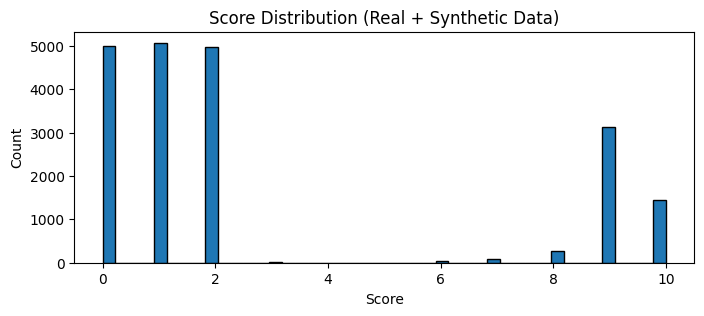

In [ ]:
# ============================================================
#  Load the augmented dataset and build score weights
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# Load files created earlier
X_full      = np.load("/mnt/data/X_negative_augmented.npy").astype(np.float32)
y           = np.load("/mnt/data/y_negative_augmented.npy").astype(np.float32)
metric_ids  = np.load("/mnt/data/metric_negative_augmented.npy").astype(int)

INPUT_DIM = X_full.shape[1]
print(f"X_full shape: {X_full.shape}")
print(f"y shape     : {y.shape}")
print(f"metric_ids  : {metric_ids.shape}")


# ------------------------------------------------------------
# Build frequency-based sample weights (rare scores → heavier)
# ------------------------------------------------------------
def compute_frequency_weights(y, min_w=1.0, max_w=20.0):
    """
    Convert the score distribution into per-sample weights.
    Rare score ranges get larger importance during training.
    """
    # score bins 0..10 → 11 total intervals
    bins = np.arange(0, 12)

    hist, _ = np.histogram(y, bins=bins)
    freq = hist / hist.sum() + 1e-6       # avoid divide-by-zero
    inv  = 1.0 / freq                     # inverse frequency

    # scale all values into [min_w, max_w]
    scaled = (inv - inv.min()) / (inv.max() - inv.min())
    scaled = min_w + scaled * (max_w - min_w)

    # assign weight to each data point
    idx = np.digitize(y, bins) - 1
    idx = np.clip(idx, 0, len(scaled)-1)

    return scaled[idx].astype(np.float32)


weights = compute_frequency_weights(y)
print("Weight scale →", weights.min(), "to", weights.max())


# quick visualization of score distribution
plt.figure(figsize=(8,3))
plt.hist(y, bins=np.linspace(0,10,45), edgecolor="black")
plt.title("Score Distribution (Real + Synthetic Data)")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()


### Train LightGBM on 1536-D Embeddings-- Public leaderboard RMSE-2.579

## 📘 Model Diagram: LightGBM Regressor (1536-D Embedding + Augmented Features)

Below is the structural diagram of the LightGBM system used in the project:

                     ┌───────────────────────────┐
                     │   Input Feature Vector     │
                     │   (1536-dimensional)       │
                     │  [embedding │ metric]      │
                     └─────────────┬──────────────┘
                                   │
                    ┌──────────────▼──────────────┐
                    │   Gradient Boosting Tree     │
                    │         Ensemble             │
                    └──────────────┬──────────────┘
                                   │
             ┌─────────────────────▼────────────────────────┐
             │ Repeated for ~3000 boosting iterations        │
             │ - Each tree fits residuals                    │
             │ - Leaves optimized for MAE (L1)               │
             │ - Uses histogram-based split finding          │
             └─────────────────────┬────────────────────────┘
                                   │
                       ┌───────────▼────────────┐
                       │ LightGBM Regularization│
                       │ - num_leaves = 63      │
                       │ - feature_fraction=0.9 │
                       │ - bagging_fraction=0.8 │
                       │ - min_data_in_leaf=50  │
                       └───────────┬────────────┘
                                   │
                        ┌──────────▼─────────┐
                        │ Final Ensemble      │
                        │ (Tree Outputs Avg.) │
                        └──────────┬──────────┘
                                   │
                     ┌─────────────▼──────────────┐
                     │   Predicted Score (0–10)   │
                     └────────────────────────────┘


In [ ]:
# ============================================================
# Train LightGBM on the full 1536-dim features + Smoothed Plots
# (fixed: use lgb.record_evaluation callback instead of evals_result arg)
# ============================================================

import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import os
import matplotlib.pyplot as plt

SEED = 42

# ============================================================
# LightGBM configuration (unchanged)
# ============================================================
params = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.03,
    "num_leaves": 63,
    "feature_fraction": 0.90,
    "bagging_fraction": 0.80,
    "bagging_freq": 5,
    "min_data_in_leaf": 50,
    "seed": SEED,
    "verbose": -1,
    "feature_pre_filter": False,
}

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

lgb_oof = np.zeros(len(y), dtype=np.float32)
lgb_models = []

# ---- store full learning curves ----
fold_mae_history = []
fold_rmse_history = []


# ============================================================
# TRAINING LOOP (fixed)
# ============================================================
for fold, (tr_idx, val_idx) in enumerate(kf.split(X_full), 1):
    print(f"\n[LightGBM] Fold {fold}/5")

    dtrain = lgb.Dataset(X_full[tr_idx], y[tr_idx])
    dvalid = lgb.Dataset(X_full[val_idx], y[val_idx])

    # record learning curves here
    evals_result = {}

    # record_evaluation callback will fill evals_result
    callbacks = [
        lgb.record_evaluation(evals_result),
        lgb.early_stopping(stopping_rounds=200, verbose=True),
        lgb.log_evaluation(period=100)
    ]

    model = lgb.train(
        params=params,
        train_set=dtrain,
        num_boost_round=3000,
        valid_sets=[dvalid],
        valid_names=["valid"],
        callbacks=callbacks,
    )

    lgb_models.append(model)

    preds = model.predict(X_full[val_idx], num_iteration=model.best_iteration)
    lgb_oof[val_idx] = preds

    print("Fold MAE:", mean_absolute_error(y[val_idx], preds))

    # ----------------------------------------------
    # Store MAE & RMSE per iteration for this fold
    # evals_result structure: {'valid': {'l1': [...], 'l2': [...], ...}}
    # prefer 'l1' (MAE) and 'l2' (MSE) if available
    valid_res = evals_result.get("valid", {})
    mae_curve = np.array(valid_res.get("l1", []), dtype=np.float32)
    if "l2" in valid_res:
        rmse_curve = np.sqrt(np.array(valid_res["l2"], dtype=np.float32))
    else:
        # fallback: approximate RMSE from MAE (not exact) or compute on preds if only best iter available
        if mae_curve.size:
            rmse_curve = np.sqrt(mae_curve**2)
        else:
            rmse_curve = np.array([])

    fold_mae_history.append(mae_curve)
    fold_rmse_history.append(rmse_curve)


# ============================================================
# FINAL OOF PERFORMANCE
# ============================================================
print("\n[LightGBM] Final OOF MAE:", mean_absolute_error(y, lgb_oof))

# ============================================================
# SAVE MODELS
# ============================================================
os.makedirs("/mnt/data/lgbm_models", exist_ok=True)
for i, m in enumerate(lgb_models, 1):
    m.save_model(f"/mnt/data/lgbm_models/lgbm_fold_{i}.txt")

# ============================================================
# 📈 SMOOTHED TRAINING CURVES
# ============================================================
def smooth(x, w=15):
    if len(x) < w:
        return x
    return np.convolve(x, np.ones(w)/w, mode="valid")

plt.figure(figsize=(12,6))

# Plot MAE curves (smoothed)
for i, c in enumerate(fold_mae_history, 1):
    if c.size:
        plt.plot(smooth(c), label=f"Fold {i} MAE (smooth)", linewidth=2)

# Plot RMSE curves (smoothed, dashed)
for i, c in enumerate(fold_rmse_history, 1):
    if c.size:
        plt.plot(smooth(c), linestyle="--", label=f"Fold {i} RMSE (smooth)", alpha=0.7)

plt.title("LightGBM Validation Curves (Smoothed MAE & RMSE)")
plt.xlabel("Iteration (smoothed window applied)")
plt.ylabel("Metric Value")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


[LightGBM] Fold 1/5
Training until validation scores don't improve for 200 rounds
[100]	train's l1: 1.98018	valid's l1: 2.38104
[200]	train's l1: 1.54409	valid's l1: 2.18723
[300]	train's l1: 1.25059	valid's l1: 2.08607
[400]	train's l1: 1.04771	valid's l1: 2.02551
[500]	train's l1: 0.888685	valid's l1: 1.98873
[600]	train's l1: 0.764438	valid's l1: 1.96238
[700]	train's l1: 0.661215	valid's l1: 1.944
[800]	train's l1: 0.576049	valid's l1: 1.9307
[900]	train's l1: 0.503401	valid's l1: 1.9188
[1000]	train's l1: 0.442624	valid's l1: 1.91129
[1100]	train's l1: 0.389431	valid's l1: 1.90314
[1200]	train's l1: 0.344129	valid's l1: 1.8995
[1300]	train's l1: 0.305256	valid's l1: 1.89525
[1400]	train's l1: 0.271465	valid's l1: 1.89199
[1500]	train's l1: 0.242239	valid's l1: 1.88903
[1600]	train's l1: 0.216559	valid's l1: 1.88662
[1700]	train's l1: 0.194628	valid's l1: 1.88529
[1800]	train's l1: 0.175173	valid's l1: 1.8838
[1900]	train's l1: 0.158285	valid's l1: 1.88224
[2000]	train's l1: 0.143

## Inference on Test Set + Distribution Plot

In [26]:
#  Build test 1536-d features
import torch
# Assumes you already have:
#   test_comb_emb : (T, 768) numpy
#   test_df       : pandas DataFrame with 'metric_id' column
device="cuda"
X_test_text = test_comb.astype(np.float32)
test_metric_id = test_df["metric_id"].values.astype(int)

metric_emb = np.load("metric_name_embeddings.npy").astype(np.float32)
test_metric_vec = metric_emb[test_metric_id]

X_test_full = np.hstack([X_test_text, test_metric_vec]).astype(np.float32)
print("Test full shape:", X_test_full.shape)

test_tensor = torch.tensor(X_test_full, dtype=torch.float32).to(device)


Test full shape: (3638, 1536)


🔍 Running LightGBM inference...
Loading: /mnt/data/lgbm_models/lgbm_fold_1.txt
Loading: /mnt/data/lgbm_models/lgbm_fold_2.txt
Loading: /mnt/data/lgbm_models/lgbm_fold_3.txt
Loading: /mnt/data/lgbm_models/lgbm_fold_4.txt
Loading: /mnt/data/lgbm_models/lgbm_fold_5.txt

Done! Test predictions computed.


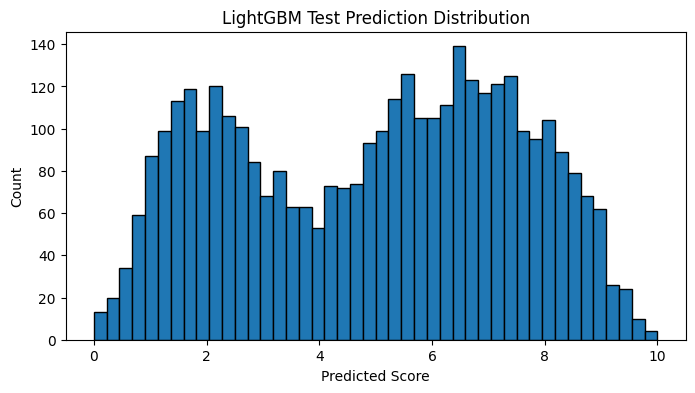

📁 Saved LGBM submission to: /mnt/data/submission_lgbm_augmented.csv


In [27]:
# ============================================================
# Inference – LightGBM (1536-dim augmented features)
# ============================================================

import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import os

print("🔍 Running LightGBM inference...")

# ------------------------------------------------------------
# REQUIREMENTS:
#   X_test_full   → (T, 1536) feature matrix from previous cell
#   test_df       → used to build submission
#   lgbm_models/  → directory with saved fold models
# ------------------------------------------------------------

model_dir = "/mnt/data/lgbm_models"

lgb_test_preds_list = []

# Load each fold model and predict
for i in range(1, 6):
    model_path = f"{model_dir}/lgbm_fold_{i}.txt"
    print("Loading:", model_path)

    booster = lgb.Booster(model_file=model_path)
    preds = booster.predict(X_test_full, num_iteration=booster.best_iteration)
    lgb_test_preds_list.append(preds)

# ------------------------------------------------------------
# Average predictions from all folds
# ------------------------------------------------------------
lgb_test_preds = np.mean(np.vstack(lgb_test_preds_list), axis=0)

# Clip to 0–10
lgb_test_preds_clipped = np.clip(lgb_test_preds, 0, 10)

print("\nDone! Test predictions computed.")

# ------------------------------------------------------------
# Plot Test Prediction Distribution
# ------------------------------------------------------------

plt.figure(figsize=(8, 4))
plt.hist(lgb_test_preds_clipped, bins=np.linspace(0, 10, 45), edgecolor="black")
plt.title("LightGBM Test Prediction Distribution")
plt.xlabel("Predicted Score")
plt.ylabel("Count")
plt.show()

# ------------------------------------------------------------
# Save Submission File
# ------------------------------------------------------------
submission_lgbm = pd.DataFrame({
    "id": np.arange(1, len(lgb_test_preds_clipped) + 1),
    "score": lgb_test_preds_clipped
})

path = "/mnt/data/submission_lgbm_augmented.csv"
submission_lgbm.to_csv(path, index=False)

print("📁 Saved LGBM submission to:", path)


### Heteroscedastic-NLL — Full Export Block (My Best Model--Public RMSE-2.055)

This section saves everything required to run the best leaderboard model
in any notebook, fully reproducible and without retraining.


In [28]:
import joblib
import numpy as np

# =============================
# 1. Collect everything needed
# =============================

export_bundle = {
    # ---- Train embeddings ----
    "train_user": train_user,
    "train_sys": train_sys,
    "train_resp": train_resp,
    "train_comb": train_comb,

    # ---- Test embeddings ----
    "test_user": test_user,
    "test_sys": test_sys,
    "test_resp": test_resp,
    "test_comb": test_comb,

    # ---- DataFrames ----
    "train_df": train_df.copy(),
    "test_df": test_df.copy(),

    # ---- Metric information ----
    "metric_names": metric_names,
    "metric_embeddings": metric_embeddings,
    "metric_to_idx": metric_to_idx,

    # ---- Target ----
    "y": train_df["score"].astype(float).values,

    # ---- Metric index arrays ----
    "train_metric_idx": train_df["metric_idx"].astype(int).values,
    "test_metric_idx": test_df["metric_idx"].astype(int).values,

    # ---- System missing flag ----
    "train_sys_missing_flag": (train_df["system_prompt"].astype(str).str.strip() == "").astype(int).values,
    "test_sys_missing_flag": (test_df["system_prompt"].astype(str).str.strip() == "").astype(int).values,

    # ---- Cleaned prompts (if needed) ----
    "train_user_prompt": train_df["user_prompt"].tolist(),
    "train_system_prompt": train_df["system_prompt"].tolist(),
    "train_response_text": train_df["response"].tolist(),

    "test_user_prompt": test_df["user_prompt"].tolist(),
    "test_system_prompt": test_df["system_prompt"].tolist(),
    "test_response_text": test_df["response"].tolist(),
}

# ======================================
# 2. Save into one single joblib bundle
# ======================================

export_path = "/mnt/data/full_training_bundle_for_nll.joblib"
joblib.dump(export_bundle, export_path)

print("Saved bundle to:", export_path)


Saved bundle to: /mnt/data/full_training_bundle_for_nll.joblib
